In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.metrics import MeanIoU
from sklearn.model_selection import train_test_split


In [ ]:
import os
import random
import numpy as np
import tensorflow as tf

def set_global_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_global_seed(42)

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

ct_dir = "/content/drive/MyDrive/Processed_Parotid/Enhanced_Individual/CT_Image"
mask_dir = "/content/drive/MyDrive/Processed_Parotid/Enhanced_Individual/P_Mask"

print("CT files:", len(os.listdir(ct_dir)))
print("Mask files:", len(os.listdir(mask_dir)))

Mounted at /content/drive
CT files: 379
Mask files: 379


In [ ]:
def load_processed_data(ct_dir, mask_dir):
    ct_list = sorted([f for f in os.listdir(ct_dir) if f.endswith('.npy')])
    mask_list = sorted([f for f in os.listdir(mask_dir) if f.endswith('.npy')])

    images, masks = [], []
    for ct_file, mask_file in zip(ct_list, mask_list):
        img = np.load(os.path.join(ct_dir, ct_file))
        mask = np.load(os.path.join(mask_dir, mask_file))
        images.append(img)
        masks.append(mask)

    X = np.expand_dims(np.array(images), axis=-1)
    y = np.array(masks)
    return X, y, ct_list, mask_list

X_filtered, y_filtered, ct_image_list_filtered, p_mask_list_filtered = load_processed_data(ct_dir, mask_dir)

print("✅ Loaded volumes:", X_filtered.shape, y_filtered.shape)

✅ Loaded volumes: (379, 192, 192, 32, 1) (379, 192, 192, 32, 3)


In [ ]:
ct_train_val, ct_test, p_mask_train_val, p_mask_test = train_test_split(
    ct_image_list_filtered, p_mask_list_filtered, test_size=0.2, random_state=42
)

ct_train, ct_val, p_mask_train, p_mask_val = train_test_split(
    ct_train_val, p_mask_train_val, test_size=0.25, random_state=42
)

filename_to_index = {fname: i for i, fname in enumerate(ct_image_list_filtered)}

X_train = X_filtered[[filename_to_index[f] for f in ct_train]]
y_train = y_filtered[[filename_to_index[f] for f in ct_train]]

X_val = X_filtered[[filename_to_index[f] for f in ct_val]]
y_val = y_filtered[[filename_to_index[f] for f in ct_val]]

X_test = X_filtered[[filename_to_index[f] for f in ct_test]]
y_test = y_filtered[[filename_to_index[f] for f in ct_test]]

print("✅ Final split sizes:")
print("Train:", X_train.shape[0])
print("Validation:", X_val.shape[0])
print("Test:", X_test.shape[0])


✅ Final split sizes:
Train: 227
Validation: 76
Test: 76


In [ ]:
import tensorflow.keras.backend as K
import tensorflow as tf

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    global tf
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection

    return (intersection + smooth) / (union + smooth)

def precision(y_true, y_pred):
    y_true_f = K.cast(K.flatten(y_true), 'float32')
    y_pred_f = K.cast(K.round(K.flatten(y_pred)), 'float32')
    true_positives = K.sum(y_true_f * y_pred_f)
    predicted_positives = K.sum(y_pred_f)
    return (true_positives + 1e-7) / (predicted_positives + 1e-7)

def recall(y_true, y_pred):
    y_true_f = K.cast(K.flatten(y_true), 'float32')
    y_pred_f = K.cast(K.round(K.flatten(y_pred)), 'float32')
    true_positives = K.sum(y_true_f * y_pred_f)
    possible_positives = K.sum(y_true_f)
    return (true_positives + 1e-7) / (possible_positives + 1e-7)

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * (p * r) / (p + r + 1e-7)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv3D, Conv3DTranspose, MaxPooling3D, concatenate, Add,
    GlobalAveragePooling3D, GlobalMaxPooling3D, Dense, Reshape,
    Multiply, Dropout, LeakyReLU, Lambda, LayerNormalization
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Conv3D, LayerNormalization, LeakyReLU, Add, Dropout

def residual_block(x, filters, dropout_rate=0.1):
    shortcut = Conv3D(filters, (1, 1, 1), padding='same')(x)
    shortcut = LayerNormalization()(shortcut)

    x = Conv3D(filters, (3, 3, 3), padding='same')(x)
    x = LayerNormalization()(x)
    x = LeakyReLU(0.01)(x)

    x = Conv3D(filters, (3, 3, 3), padding='same')(x)
    x = LayerNormalization()(x)
    x = LeakyReLU(0.01)(x)

    x = Conv3D(filters, (3, 3, 3), padding='same')(x)
    x = LayerNormalization()(x)

    x = Add()([x, shortcut])
    x = LeakyReLU(0.01)(x)
    x = Dropout(dropout_rate)(x)
    return x

import tensorflow as tf
from tensorflow.keras.layers import (
    GlobalAveragePooling3D, GlobalMaxPooling3D, Dense, Reshape, Multiply,
    Conv3D, LayerNormalization, LeakyReLU, Lambda, concatenate
)

def cbam_block(input_tensor, ratio=8):
    channel = input_tensor.shape[-1]

    avg_pool = GlobalAveragePooling3D()(input_tensor)
    max_pool = GlobalMaxPooling3D()(input_tensor)

    shared_dense_one = Dense(channel // ratio, use_bias=False)
    shared_dense_two = Dense(channel, use_bias=False)

    avg_out = shared_dense_one(avg_pool)
    avg_out = LayerNormalization()(avg_out)
    avg_out = LeakyReLU(0.01)(avg_out)
    avg_out = shared_dense_two(avg_out)

    max_out = shared_dense_one(max_pool)
    max_out = LayerNormalization()(max_out)
    max_out = LeakyReLU(0.01)(max_out)
    max_out = shared_dense_two(max_out)

    channel_attention = tf.keras.layers.Activation('sigmoid')(avg_out + max_out)
    channel_attention = Reshape((1, 1, 1, channel))(channel_attention)
    x = Multiply()([input_tensor, channel_attention])

    avg_pool_spatial = Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(x)
    max_pool_spatial = Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(x)
    concat = concatenate([avg_pool_spatial, max_pool_spatial], axis=-1)

    spatial_attention = Conv3D(1, (7, 7, 7), padding='same', activation='sigmoid')(concat)
    x = Multiply()([x, spatial_attention])

    return x

def akt_Attn(input_shape, num_classes):
    inputs = Input(input_shape)

    c1 = residual_block(inputs, 16)
    p1 = MaxPooling3D(pool_size=(2, 2, 2))(c1)

    c2 = residual_block(p1, 32)
    p2 = MaxPooling3D(pool_size=(2, 2, 2))(c2)

    c3 = residual_block(p2, 64)
    p3 = MaxPooling3D(pool_size=(2, 2, 2))(c3)

    c4 = residual_block(p3, 128)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)

    c5 = residual_block(p4, 256)
    p5 = MaxPooling3D(pool_size=(2, 2, 2))(c5)

    b1 = residual_block(p5, 256)
    b2 = residual_block(b1, 256)

    u5 = Conv3DTranspose(256, (2, 2, 2), strides=2, padding='same')(b2)
    d5 = concatenate([u5, cbam_block(c5)])
    d5 = residual_block(d5, 256)

    u4 = Conv3DTranspose(128, (2, 2, 2), strides=2, padding='same')(d5)
    d4 = concatenate([u4, cbam_block(c4)])
    d4 = residual_block(d4, 128)

    u3 = Conv3DTranspose(64, (2, 2, 2), strides=2, padding='same')(d4)
    d3 = concatenate([u3, cbam_block(c3)])
    d3 = residual_block(d3, 64)

    u2 = Conv3DTranspose(32, (2, 2, 2), strides=2, padding='same')(d3)
    d2 = concatenate([u2, cbam_block(c2)])
    d2 = residual_block(d2, 32)

    u1 = Conv3DTranspose(16, (2, 2, 2), strides=2, padding='same')(d2)
    d1 = concatenate([u1, cbam_block(c1)])
    d1 = residual_block(d1, 16)

    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(d1)
    return Model(inputs=inputs, outputs=outputs)


input_shape = (192, 192, 32, 1)
num_classes = 3
modelA = akt_Attn(input_shape, num_classes)

modelA.compile(
    optimizer = Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[
        dice_coefficient,
        iou_metric,
        tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

modelA.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 192, 192,  │          0 │ -                 │
│ (InputLayer)        │ 32, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 192, 192,  │        448 │ input_layer[0][0] │
│                     │ 32, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 192, 192,  │         32 │ conv3d_1[0][0]    │
│ (LayerNormalizatio… │ 32, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 192, 192,  │          0 │ layer_normalizat… │
│ (LeakyReLU)         │ 32, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 192, 192,  │      6,928 │ leaky_re_lu[0][0] │
│                     │ 32, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 192, 192,  │         32 │ conv3d_2[0][0]    │
│ (LayerNormalizatio… │ 32, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 192, 192,  │          0 │ layer_normalizat… │
│ (LeakyReLU)         │ 32, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 192, 192,  │      6,928 │ leaky_re_lu_1[0]… │
│                     │ 32, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 192, 192,  │         32 │ input_layer[0][0] │
│                     │ 32, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 192, 192,  │         32 │ conv3d_3[0][0]    │
│ (LayerNormalizatio… │ 32, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 192, 192,  │         32 │ conv3d[0][0]      │
│ (LayerNormalizatio… │ 32, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 192, 192,  │          0 │ layer_normalizat… │
│                     │ 32, 16)           │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 192, 192,  │          0 │ add[0][0]         │
│ (LeakyReLU)         │ 32, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 192, 192,  │          0 │ leaky_re_lu_2[0]… │
│                     │ 32, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 96, 96,    │          0 │ dropout[0][0]     │
│ (MaxPooling3D)      │ 16, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 96, 96,    │     13,856 │ max_pooling3d[0]… │
│                     │ 16, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 96, 96,    │         64 │ conv3d_5[0][0]  

 Total params: 27,200,006 (103.76 MB)

 Trainable params: 27,200,006 (103.76 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class SaveBestDSCWithMinLoss(tf.keras.callbacks.Callback):
    def __init__(self, filepath):
        super(SaveBestDSCWithMinLoss, self).__init__()
        self.filepath = filepath
        self.best_dice = -1.0
        self.best_val_loss = float("inf")

    def on_epoch_end(self, epoch, logs=None):
        current_dice = logs.get('val_dice_coefficient')
        current_loss = logs.get('val_loss')

        if current_dice is None or current_loss is None:
            return

        if (current_dice > self.best_dice) or (
            current_dice == self.best_dice and current_loss < self.best_val_loss):

            self.best_dice = current_dice
            self.best_val_loss = current_loss
            self.model.save(self.filepath)
            print(f"\n✅ Saved best model at epoch {epoch+1} with DSC {current_dice:.4f} and val_loss {current_loss:.4f}")


In [ ]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    factor=0.6,
    min_lr=1e-5,
    verbose=1
)

custom_dsc_checkpoint = SaveBestDSCWithMinLoss("modelA.keras")

historyA = modelA.fit(
    X_train, y_train,
    batch_size=5,
    epochs=80,
    validation_data=(X_val, y_val),
    callbacks=[
        lr_scheduler,
        custom_dsc_checkpoint
    ]
)

Epoch 1/80
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - categorical_accuracy: 0.8602 - dice_coefficient: 0.8006 - iou_metric: 0.7241 - loss: 0.4404 - precision: 0.8650 - recall: 0.8500
✅ Saved best model at epoch 1 with DSC 0.9811 and val_loss 0.0710
46/46 ━━━━━━━━━━━━━━━━━━━━ 91s 872ms/step - categorical_accuracy: 0.8622 - dice_coefficient: 0.8030 - iou_metric: 0.7271 - loss: 0.4348 - precision: 0.8670 - recall: 0.8521 - val_categorical_accuracy: 0.9884 - val_dice_coefficient: 0.9811 - val_iou_metric: 0.9629 - val_loss: 0.0710 - val_precision: 0.9884 - val_recall: 0.9884 - learning_rate: 0.0010
Epoch 2/80
46/46 ━━━━━━━━━━━━━━━━━━━━ 33s 715ms/step - categorical_accuracy: 0.9879 - dice_coefficient: 0.9702 - iou_metric: 0.9421 - loss: 0.0806 - precision: 0.9883 - recall: 0.9874 - val_categorical_accuracy: 0.9884 - val_dice_coefficient: 0.9805 - val_iou_metric: 0.9617 - val_loss: 0.0685 - val_precision: 0.9884 - val_recall: 0.9884 - learning_rate: 0.0010
Epoch 3/80
46/46 ━━━━━━━━━━━━━━━━━━━

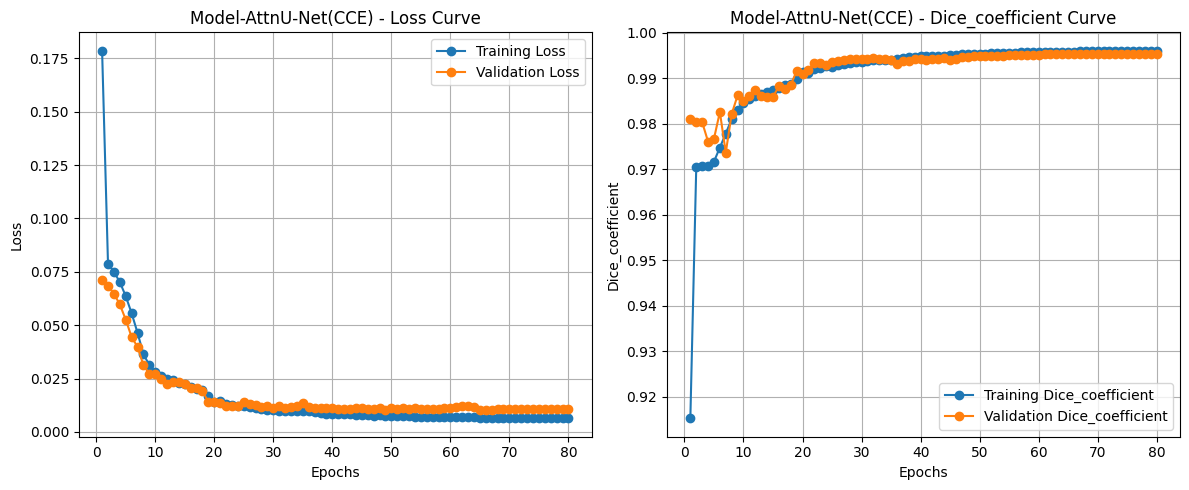

In [ ]:
import matplotlib.pyplot as plt

def plot_training_curves(history, model_name="Model"):
    epochs = range(1, len(history.history['loss']) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], 'o-', label='Training Loss')
    plt.plot(epochs, history.history.get('val_loss', []), 'o-', label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{model_name} - Loss Curve")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    metric = 'accuracy' if 'accuracy' in history.history else 'dice_coefficient'

    if metric in history.history:
        plt.plot(epochs, history.history[metric], 'o-', label=f'Training {metric.capitalize()}')
        plt.plot(epochs, history.history.get(f'val_{metric}', []), 'o-', label=f'Validation {metric.capitalize()}')
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.title(f"{model_name} - {metric.capitalize()} Curve")
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_curves(historyA, model_name="Model-AttnU-Net(CCE)")

# Final of mDSC+FL (Unet)

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from skimage import io, transform
import os
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.metrics import MeanIoU
kernel_initializer =  'he_uniform'
import keras
import keras.utils
from keras import utils as np_utils
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split

In [ ]:
import tensorflow.keras.backend as K
import tensorflow as tf


def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection

    return (intersection + smooth) / (union + smooth)

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    global tf
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

In [ ]:
import tensorflow as tf

def focal_loss(alpha=[0.3, 0.35, 0.35], gamma=1.0):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 1e-6, 1.0 - 1e-6)

        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = tf.pow(1.0 - y_pred, gamma)

        alpha_tensor = tf.constant(alpha, dtype=tf.float32)
        alpha_tensor = tf.reshape(alpha_tensor, [1, 1, 1, 1, -1])
        weight *= alpha_tensor

        focal = weight * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(focal, axis=-1))

    return loss

import tensorflow as tf

def classwise_dice_loss(smooth=1e-6):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        num_classes = tf.shape(y_true)[-1]

        def compute_sample_loss(y_t, y_p):
            loss_sum = tf.constant(0.0)
            i = tf.constant(0)

            def body(i, total_loss):
                y_t_c = y_t[..., i]
                y_p_c = y_p[..., i]

                intersection = tf.reduce_sum(y_t_c * y_p_c)
                union = tf.reduce_sum(y_t_c) + tf.reduce_sum(y_p_c)
                dice = (2. * intersection + smooth) / (union + smooth)

                return i + 1, total_loss + (1.0 - dice)

            _, total_loss = tf.while_loop(
                cond=lambda i, *_: i < num_classes,
                body=body,
                loop_vars=[i, loss_sum]
            )

            return total_loss / tf.cast(num_classes, tf.float32)

        per_sample_loss = tf.map_fn(
            lambda x: compute_sample_loss(x[0], x[1]),
            (y_true, y_pred),
            dtype=tf.float32
        )

        return tf.reduce_mean(per_sample_loss)

    return loss

def combined_loss(y_true, y_pred):
    dice = classwise_dice_loss()(y_true, y_pred)
    focal = focal_loss(alpha=[0.3, 0.35, 0.35])(y_true, y_pred)
    return 0.7 * dice + 0.3 * focal

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv3D, Conv3DTranspose, MaxPooling3D, concatenate, Add,
    GlobalAveragePooling3D, GlobalMaxPooling3D, Dense, Reshape,
    Multiply, Dropout, LeakyReLU, Lambda, LayerNormalization
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Conv3D, LayerNormalization, LeakyReLU, Add, Dropout

def residual_block(x, filters, dropout_rate=0.1):
    shortcut = Conv3D(filters, (1, 1, 1), padding='same')(x)
    shortcut = LayerNormalization()(shortcut)

    x = Conv3D(filters, (3, 3, 3), padding='same')(x)
    x = LayerNormalization()(x)
    x = LeakyReLU(0.01)(x)

    x = Conv3D(filters, (3, 3, 3), padding='same')(x)
    x = LayerNormalization()(x)
    x = LeakyReLU(0.01)(x)

    x = Conv3D(filters, (3, 3, 3), padding='same')(x)
    x = LayerNormalization()(x)

    x = Add()([x, shortcut])
    x = LeakyReLU(0.01)(x)
    x = Dropout(dropout_rate)(x)
    return x

import tensorflow as tf
from tensorflow.keras.layers import (
    GlobalAveragePooling3D, GlobalMaxPooling3D, Dense, Reshape, Multiply,
    Conv3D, LayerNormalization, LeakyReLU, Lambda, concatenate
)

def cbam_block(input_tensor, ratio=8):
    channel = input_tensor.shape[-1]

    avg_pool = GlobalAveragePooling3D()(input_tensor)
    max_pool = GlobalMaxPooling3D()(input_tensor)

    shared_dense_one = Dense(channel // ratio, use_bias=False)
    shared_dense_two = Dense(channel, use_bias=False)

    avg_out = shared_dense_one(avg_pool)
    avg_out = LayerNormalization()(avg_out)
    avg_out = LeakyReLU(0.01)(avg_out)
    avg_out = shared_dense_two(avg_out)

    max_out = shared_dense_one(max_pool)
    max_out = LayerNormalization()(max_out)
    max_out = LeakyReLU(0.01)(max_out)
    max_out = shared_dense_two(max_out)

    channel_attention = tf.keras.layers.Activation('sigmoid')(avg_out + max_out)
    channel_attention = Reshape((1, 1, 1, channel))(channel_attention)
    x = Multiply()([input_tensor, channel_attention])

    avg_pool_spatial = Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(x)
    max_pool_spatial = Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(x)
    concat = concatenate([avg_pool_spatial, max_pool_spatial], axis=-1)

    spatial_attention = Conv3D(1, (7, 7, 7), padding='same', activation='sigmoid')(concat)
    x = Multiply()([x, spatial_attention])

    return x

def akt_Attn(input_shape, num_classes):
    inputs = Input(input_shape)

    c1 = residual_block(inputs, 16)
    p1 = MaxPooling3D(pool_size=(2, 2, 2))(c1)

    c2 = residual_block(p1, 32)
    p2 = MaxPooling3D(pool_size=(2, 2, 2))(c2)

    c3 = residual_block(p2, 64)
    p3 = MaxPooling3D(pool_size=(2, 2, 2))(c3)

    c4 = residual_block(p3, 128)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)

    c5 = residual_block(p4, 256)
    p5 = MaxPooling3D(pool_size=(2, 2, 2))(c5)

    b1 = residual_block(p5, 256)
    b2 = residual_block(b1, 256)

    u5 = Conv3DTranspose(256, (2, 2, 2), strides=2, padding='same')(b2)
    d5 = concatenate([u5, cbam_block(c5)])
    d5 = residual_block(d5, 256)

    u4 = Conv3DTranspose(128, (2, 2, 2), strides=2, padding='same')(d5)
    d4 = concatenate([u4, cbam_block(c4)])
    d4 = residual_block(d4, 128)

    u3 = Conv3DTranspose(64, (2, 2, 2), strides=2, padding='same')(d4)
    d3 = concatenate([u3, cbam_block(c3)])
    d3 = residual_block(d3, 64)

    u2 = Conv3DTranspose(32, (2, 2, 2), strides=2, padding='same')(d3)
    d2 = concatenate([u2, cbam_block(c2)])
    d2 = residual_block(d2, 32)

    u1 = Conv3DTranspose(16, (2, 2, 2), strides=2, padding='same')(d2)
    d1 = concatenate([u1, cbam_block(c1)])
    d1 = residual_block(d1, 16)

    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(d1)
    return Model(inputs=inputs, outputs=outputs)

input_shape = (192, 192, 32, 1)
num_classes = 3
modelB = akt_Attn(input_shape, num_classes)

modelB.compile(
    optimizer=Adam(learning_rate=.001),
    loss= combined_loss,
    metrics=[
        dice_coefficient,
        iou_metric,
        tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

modelB.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 192, 192,  │          0 │ -                 │
│ (InputLayer)        │ 32, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_55 (Conv3D)  │ (None, 192, 192,  │        448 │ input_layer_1[0]… │
│                     │ 32, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 192, 192,  │         32 │ conv3d_55[0][0]   │
│ (LayerNormalizatio… │ 32, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_46      │ (None, 192, 192,  │          0 │ layer_normalizat… │
│ (LeakyReLU)         │ 32, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_56 (Conv3D)  │ (None, 192, 192,  │      6,928 │ leaky_re_lu_46[0… │
│                     │ 32, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 192, 192,  │         32 │ conv3d_56[0][0]   │
│ (LayerNormalizatio… │ 32, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_47      │ (None, 192, 192,  │          0 │ layer_normalizat… │
│ (LeakyReLU)         │ 32, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_57 (Conv3D)  │ (None, 192, 192,  │      6,928 │ leaky_re_lu_47[0… │
│                     │ 32, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_54 (Conv3D)  │ (None, 192, 192,  │         32 │ input_layer_1[0]… │
│                     │ 32, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 192, 192,  │         32 │ conv3d_57[0][0]   │
│ (LayerNormalizatio… │ 32, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 192, 192,  │         32 │ conv3d_54[0][0]   │
│ (LayerNormalizatio… │ 32, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 192, 192,  │          0 │ layer_normalizat… │
│                     │ 32, 16)           │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_48      │ (None, 192, 192,  │          0 │ add_17[0][0]      │
│ (LeakyReLU)         │ 32, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 192, 192,  │          0 │ leaky_re_lu_48[0… │
│ (Dropout)           │ 32, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_5     │ (None, 96, 96,    │          0 │ dropout_12[0][0]  │
│ (MaxPooling3D)      │ 16, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_59 (Conv3D)  │ (None, 96, 96,    │     13,856 │ max_pooling3d_5[… │
│                     │ 16, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 96, 96,    │         64 │ conv3d_59[0][0] 

 Total params: 27,200,006 (103.76 MB)

 Trainable params: 27,200,006 (103.76 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class SaveBestDSCWithMinLoss(tf.keras.callbacks.Callback):
    def __init__(self, filepath):
        super(SaveBestDSCWithMinLoss, self).__init__()
        self.filepath = filepath
        self.best_dice = -1.0
        self.best_val_loss = float("inf")

    def on_epoch_end(self, epoch, logs=None):
        current_dice = logs.get('val_dice_coefficient')
        current_loss = logs.get('val_loss')

        if current_dice is None or current_loss is None:
            return

        if (current_dice > self.best_dice) or (
            current_dice == self.best_dice and current_loss < self.best_val_loss):

            self.best_dice = current_dice
            self.best_val_loss = current_loss
            self.model.save(self.filepath)
            print(f"\n✅ Saved best model at epoch {epoch+1} with DSC {current_dice:.4f} and val_loss {current_loss:.4f}")


In [ ]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    factor=0.6,
    min_lr=1e-5,
    verbose=1
)

custom_dsc_checkpoint = SaveBestDSCWithMinLoss("ModelB.keras")

historyB = modelB.fit(
    X_train, y_train,
    batch_size=5,
    epochs=80,
    validation_data=(X_val, y_val),
    callbacks=[
        lr_scheduler,
        custom_dsc_checkpoint
    ]
)

Epoch 1/80


Instructions for updating:
Use fn_output_signature instead


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - categorical_accuracy: 0.9300 - dice_coefficient: 0.8972 - iou_metric: 0.8466 - loss: 0.4922 - precision: 0.9417 - recall: 0.9184
✅ Saved best model at epoch 1 with DSC 0.9679 and val_loss 0.4682
46/46 ━━━━━━━━━━━━━━━━━━━━ 86s 851ms/step - categorical_accuracy: 0.9310 - dice_coefficient: 0.8984 - iou_metric: 0.8480 - loss: 0.4919 - precision: 0.9425 - recall: 0.9195 - val_categorical_accuracy: 0.9884 - val_dice_coefficient: 0.9679 - val_iou_metric: 0.9379 - val_loss: 0.4682 - val_precision: 0.9884 - val_recall: 0.9884 - learning_rate: 0.0010
Epoch 2/80
46/46 ━━━━━━━━━━━━━━━━━━━━ 33s 722ms/step - categorical_accuracy: 0.9875 - dice_coefficient: 0.9551 - iou_metric: 0.9140 - loss: 0.4642 - precision: 0.9886 - recall: 0.9860 - val_categorical_accuracy: 0.9672 - val_dice_coefficient: 0.9666 - val_iou_metric: 0.9354 - val_loss: 0.4048 - val_precision: 0.9773 - val_recall: 0.9643 - learning_rate: 0.0010
Epoch 3/80
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/

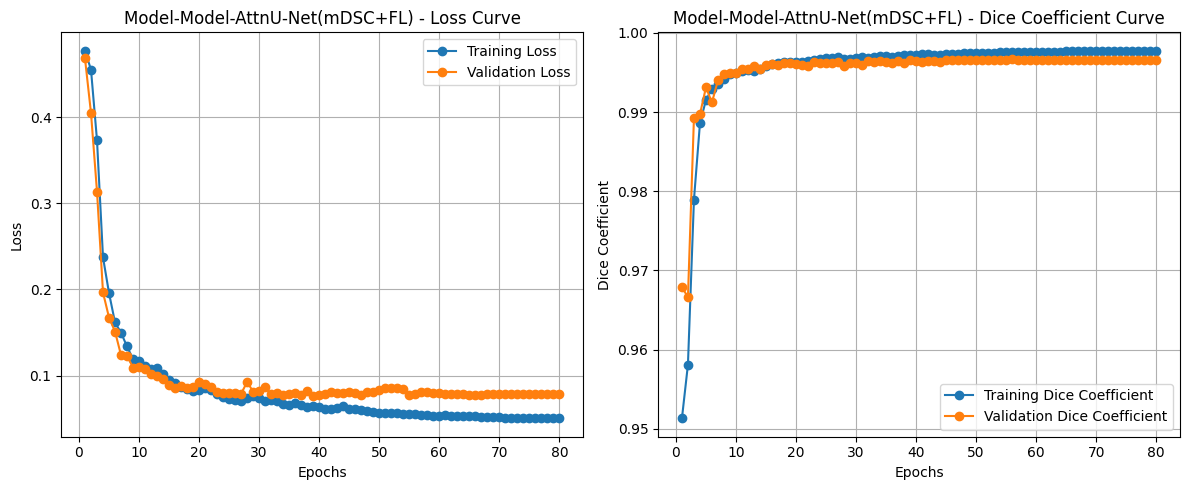

In [ ]:
import matplotlib.pyplot as plt

def plot_training_curves(historyB, model_name="Model"):
    epochs = range(1, len(historyB.history['loss']) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, historyB.history['loss'], 'o-', label='Training Loss')
    plt.plot(epochs, historyB.history.get('val_loss', []), 'o-', label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{model_name} - Loss Curve")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    metric = 'dice_coefficient' if 'dice_coefficient' in historyB.history else 'accuracy'

    if metric in historyB.history:
        plt.plot(epochs, historyB.history[metric], 'o-', label=f'Training {metric.replace("_", " ").title()}')
        plt.plot(epochs, historyB.history.get(f'val_{metric}', []), 'o-', label=f'Validation {metric.replace("_", " ").title()}')
        plt.xlabel("Epochs")
        plt.ylabel(metric.replace("_", " ").title())
        plt.title(f"{model_name} - {metric.replace('_', ' ').title()} Curve")
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()
plot_training_curves(historyB, model_name="Model-Model-AttnU-Net(mDSC+FL)")


# Compare

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def iou_score(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def compare_models_on_volume_range(volume_index, slice_start, slice_end, modelA, modelB, model_names=["Model 1", "Model 2"]):
    test_image = np.expand_dims(X_test[volume_index], axis=0)
    true_mask = np.argmax(y_test[volume_index], axis=-1)

    pred1 = np.argmax(modelA.predict(test_image)[0], axis=-1)
    pred2 = np.argmax(modelB.predict(test_image)[0], axis=-1)

    num_slices = slice_end - slice_start + 1
    fig, axes = plt.subplots(num_slices, 4, figsize=(20, 4 * num_slices))

    for i, n in enumerate(range(slice_start, slice_end + 1)):
        img = test_image[0, :, :, n, 0]
        gt = true_mask[:, :, n]
        p1 = pred1[:, :, n]
        p2 = pred2[:, :, n]

        gt_bin = (gt > 0).astype(np.float32)
        p1_bin = (p1 > 0).astype(np.float32)
        p2_bin = (p2 > 0).astype(np.float32)

        dice1 = dice_coefficient(gt_bin, p1_bin)
        dice2 = dice_coefficient(gt_bin, p2_bin)
        iou1 = iou_score(gt_bin, p1_bin)
        iou2 = iou_score(gt_bin, p2_bin)

        axes[i, 0].imshow(img, cmap="gray")
        axes[i, 0].set_title("CT Image", fontsize=14, fontweight='bold')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(gt, cmap="jet", vmin=0, vmax=2)
        axes[i, 1].set_title("Ground Truth", fontsize=14, fontweight='bold')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(p1, cmap="jet", vmin=0, vmax=2)
        axes[i, 2].set_title(f"{model_names[0]}\nDSC: {dice1:.3f}, IoU: {iou1:.3f}", fontsize=12)
        axes[i, 2].axis('off')

        axes[i, 3].imshow(p2, cmap="jet", vmin=0, vmax=2)
        axes[i, 3].set_title(f"{model_names[1]}\nDSC: {dice2:.3f}, IoU: {iou2:.3f}", fontsize=12)
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()


## Categorical entropy loss is batter

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


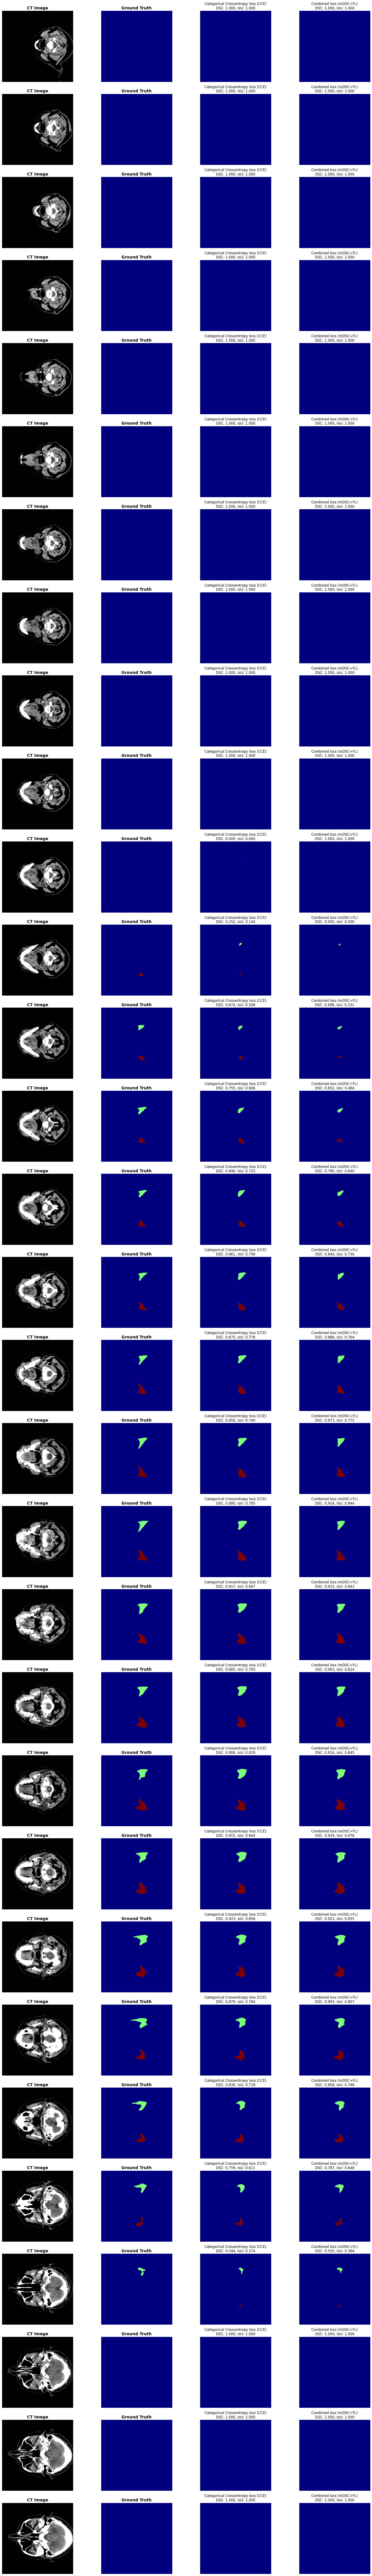

In [ ]:
compare_models_on_volume_range(
    volume_index=5,
    slice_start=1,
    slice_end=31,
    modelA=modelA,
    modelB=modelB,
    model_names=["Categorical Crossentropy loss (CCE)" , "Combined loss (mDSC+FL)"]
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


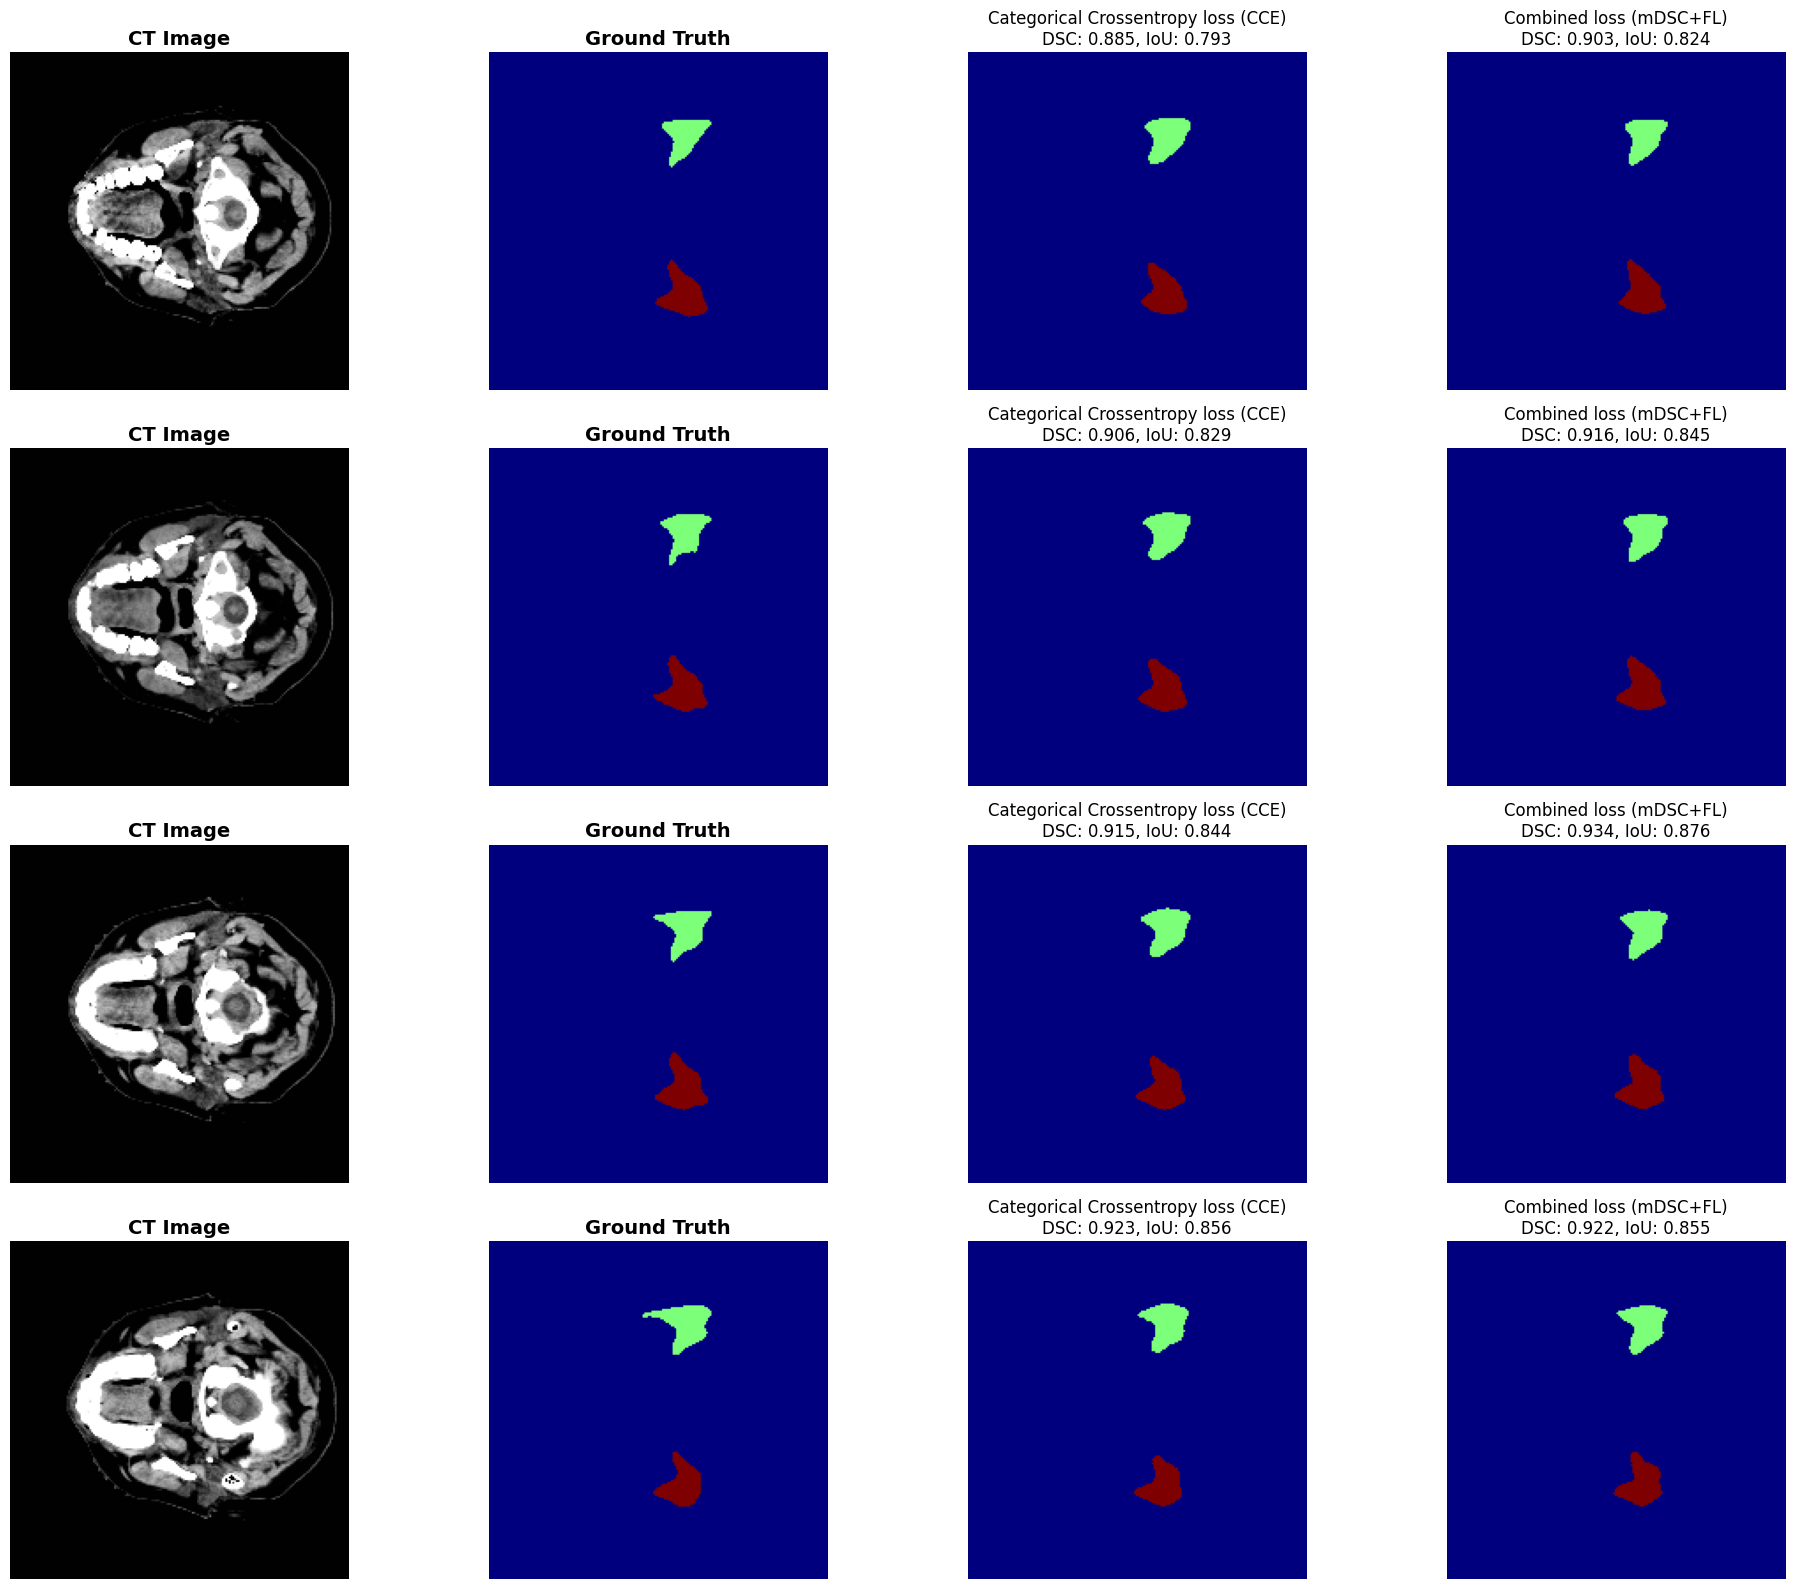

In [ ]:
compare_models_on_volume_range(
    volume_index=5,
    slice_start=21,
    slice_end=24,
    modelA=modelA,
    modelB=modelB,
    model_names=["Categorical Crossentropy loss (CCE)" , "Combined loss (mDSC+FL)" ]
)

In [ ]:
def compute_metrics(true_mask, pred_mask, smooth=1e-7):
    true_binary = (true_mask == 1).astype(np.float32)
    pred_binary = (pred_mask == 1).astype(np.float32)
    intersection = np.sum(true_binary * pred_binary)
    dice = (2. * intersection + smooth) / (np.sum(true_binary) + np.sum(pred_binary) + smooth)
    iou = (intersection + smooth) / (np.sum(true_binary) + np.sum(pred_binary) - intersection + smooth)
    return dice, iou

def evaluate_per_volume(model, X, y_true):
    dice_scores = []
    for i in range(len(X)):
        x = np.expand_dims(X[i], axis=0)
        y = np.argmax(y_true[i], axis=-1)
        pred = np.argmax(model.predict(x)[0], axis=-1)
        dice, _ = compute_metrics(y, pred)
        dice_scores.append(dice)
    return dice_scores

In [ ]:
diceA = evaluate_per_volume(modelA, X_test, y_test)
diceB = evaluate_per_volume(modelB, X_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━

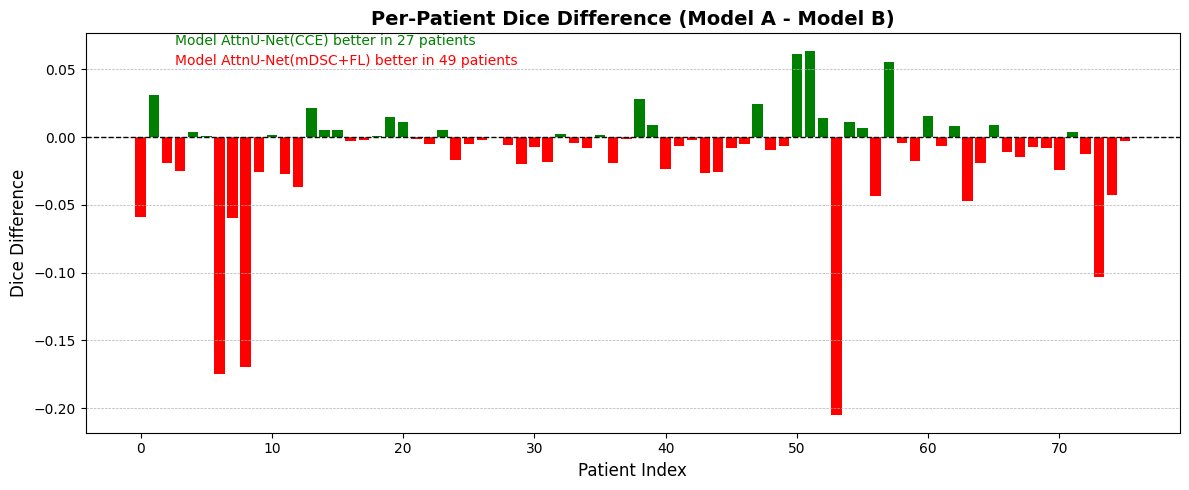

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

delta_dice = np.array(diceA) - np.array(diceB)

plt.figure(figsize=(12, 5))
bars = plt.bar(range(len(delta_dice)), delta_dice, color=['green' if x > 0 else 'red' for x in delta_dice])
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title("Per-Patient Dice Difference (Model A - Model B)", fontsize=14, fontweight='bold')
plt.xlabel("Patient Index", fontsize=12)
plt.ylabel("Dice Difference", fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.5)

better_A = np.sum(delta_dice > 0)
better_B = np.sum(delta_dice < 0)
plt.figtext(0.15, 0.9, f"Model AttnU-Net(CCE) better in {better_A} patients", fontsize=10, color='green')
plt.figtext(0.15, 0.86, f"Model AttnU-Net(mDSC+FL) better in {better_B} patients", fontsize=10, color='red')

plt.tight_layout()
plt.show()

In [ ]:
stat, p_value = wilcoxon(diceA, diceB)
print(f"Wilcoxon signed-rank test statistic = {stat:.4f}, p-value = {p_value:.5f}")

if p_value < 0.05:
    print("➡️ Statistically significant difference between Model A and Model B (p < 0.05)")
else:
    print("ℹ️ No statistically significant difference (p ≥ 0.05)")

Wilcoxon signed-rank test statistic = 907.0000, p-value = 0.00399
➡️ Statistically significant difference between Model A and Model B (p < 0.05)


## Bland–Altman Plot

In [ ]:
diceA = evaluate_per_volume(modelA, X_test, y_test)
diceB = evaluate_per_volume(modelB, X_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━

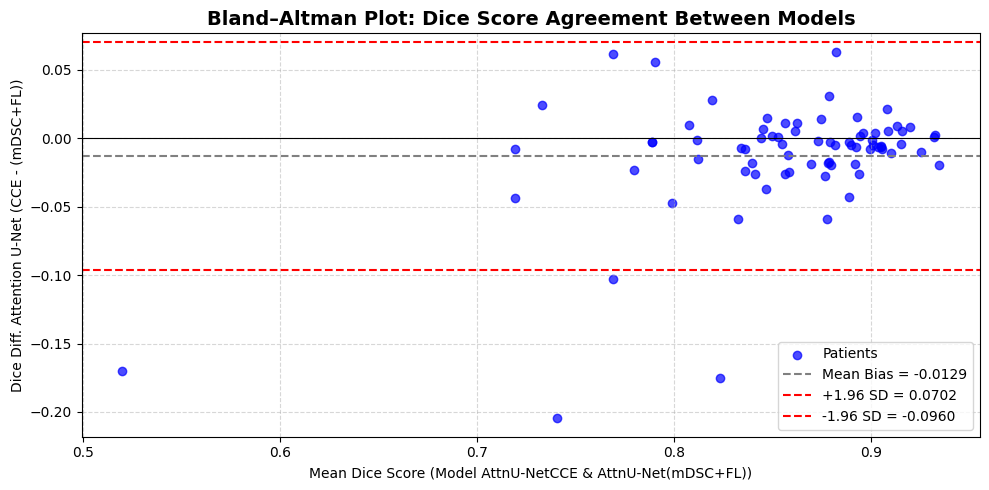

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

diceA = np.array(diceA)
diceB = np.array(diceB)

mean_dice = (diceA + diceB) / 2
diff_dice = diceA - diceB

bias = np.mean(diff_dice)
std_diff = np.std(diff_dice)
loa_upper = bias + 1.96 * std_diff
loa_lower = bias - 1.96 * std_diff

plt.figure(figsize=(10, 5))
plt.scatter(mean_dice, diff_dice, color='blue', alpha=0.7, label='Patients')
plt.axhline(bias, color='gray', linestyle='--', label=f'Mean Bias = {bias:.4f}')
plt.axhline(loa_upper, color='red', linestyle='--', label=f'+1.96 SD = {loa_upper:.4f}')
plt.axhline(loa_lower, color='red', linestyle='--', label=f'-1.96 SD = {loa_lower:.4f}')
plt.axhline(0, color='black', linewidth=0.8)

plt.title("Bland–Altman Plot: Dice Score Agreement Between Models", fontsize=14, fontweight='bold')
plt.xlabel("Mean Dice Score (Model AttnU-NetCCE & AttnU-Net(mDSC+FL))", fontsize=10)
plt.ylabel("Dice Diff. Attention U-Net (CCE - (mDSC+FL))", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

## Combined loss (BL+FL) is better

 ## **Organ-wise** **Dice/IoU** **Computation**

In [ ]:
def compute_dice_iou_classwise(y_true, y_pred, n_classes):
    dice_per_class = []
    iou_per_class = []

    for c in range(1, n_classes):
        true_c = (y_true == c).astype(np.float32)
        pred_c = (y_pred == c).astype(np.float32)

        if np.sum(true_c) + np.sum(pred_c) == 0:
            dice_per_class.append(np.nan)
            iou_per_class.append(np.nan)
            continue

        intersection = np.sum(true_c * pred_c)
        union = np.sum(true_c) + np.sum(pred_c)
        dice = (2. * intersection + 1e-7) / (union + 1e-7)
        iou = (intersection + 1e-7) / (np.sum(true_c) + np.sum(pred_c) - intersection + 1e-7)

        dice_per_class.append(dice)
        iou_per_class.append(iou)

    return dice_per_class, iou_per_class

In [ ]:
diceA_all = []
diceB_all = []
iouA_all = []
iouB_all = []

for i in range(len(X_test)):
    x = np.expand_dims(X_test[i], axis=0)
    y_true = np.argmax(y_test[i], axis=-1)

    predA = np.argmax(modelA.predict(x)[0], axis=-1)
    predB = np.argmax(modelB.predict(x)[0], axis=-1)

    diceA, iouA = compute_dice_iou_classwise(y_true, predA, num_classes)
    diceB, iouB = compute_dice_iou_classwise(y_true, predB, num_classes)

    diceA_all.append(diceA)
    diceB_all.append(diceB)
    iouA_all.append(iouA)
    iouB_all.append(iouB)

diceA_all = np.array(diceA_all)
diceB_all = np.array(diceB_all)
iouA_all = np.array(iouA_all)
iouB_all = np.array(iouB_all)

mean_diceA = np.nanmean(diceA_all, axis=0)
mean_diceB = np.nanmean(diceB_all, axis=0)
mean_iouA = np.nanmean(iouA_all, axis=0)
mean_iouB = np.nanmean(iouB_all, axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━

In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display

class_names = ["Parotid Left", "Parotid Right"]

diceA_all = np.array(diceA_all)
diceB_all = np.array(diceB_all)
iouA_all = np.array(iouA_all)
iouB_all = np.array(iouB_all)

def compute_metrics(a_vals, b_vals, metric_label, organ):
    return [
        {
            "Organ": organ,
            "Metric": f"{metric_label} Mean",
            "Model A": np.nanmean(a_vals),
            "Model B": np.nanmean(b_vals),
            "A - B": np.nanmean(a_vals) - np.nanmean(b_vals)
        },
        {
            "Organ": organ,
            "Metric": f"{metric_label} Std",
            "Model A": np.nanstd(a_vals),
            "Model B": np.nanstd(b_vals),
            "A - B": np.nanstd(a_vals) - np.nanstd(b_vals)
        },
        {
            "Organ": organ,
            "Metric": f"{metric_label} Median",
            "Model A": np.nanmedian(a_vals),
            "Model B": np.nanmedian(b_vals),
            "A - B": np.nanmedian(a_vals) - np.nanmedian(b_vals)
        }
    ]

rows = []
for i, organ in enumerate(class_names):
    rows += compute_metrics(diceA_all[:, i], diceB_all[:, i], "Dice", organ)
    rows += compute_metrics(iouA_all[:, i], iouB_all[:, i], "IoU", organ)

comparison_df = pd.DataFrame(rows)
display(comparison_df)

Organ       Metric   Model A   Model B     A - B
0    Parotid Left    Dice Mean  0.848844  0.861770 -0.012926
1    Parotid Left     Dice Std  0.075513  0.057465  0.018048
2    Parotid Left  Dice Median  0.865655  0.872407 -0.006752
3    Parotid Left     IoU Mean  0.743894  0.761270 -0.017376
4    Parotid Left      IoU Std  0.100083  0.082593  0.017489
5    Parotid Left   IoU Median  0.763136  0.773694 -0.010558
6   Parotid Right    Dice Mean  0.836777  0.842324 -0.005547
7   Parotid Right     Dice Std  0.099615  0.112922 -0.013307
8   Parotid Right  Dice Median  0.857330  0.869218 -0.011888
9   Parotid Right     IoU Mean  0.728953  0.739847 -0.010895
10  Parotid Right      IoU Std  0.114149  0.128088 -0.013939
11  Parotid Right   IoU Median  0.750287  0.768689 -0.018402

In [ ]:
output_path = "/content/modelBL.5_comparison_metrics.xlsx"
comparison_df.to_excel(output_path, index=False)

from google.colab import files
files.download(output_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>